In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from scipy.stats import *
import os, sys
sys.path.append('/stanley/WangLab/Connie/02.TEMPOmap/03.revision1000Gene/code')
from matplotlib import pyplot as plt
import seaborn as sns
from copy import copy
from helper import *

## Input

In [3]:
adata = sc.read_h5ad('Z:/Data/Analyzed/2022-09-06-Rena-TEMPOmap1000GeneHeLa3/output/2022-10-13-Rena-FUCCI-raw.h5ad')
adata

AnnData object with n_obs × n_vars = 17741 × 998
    obs: 'orig_index', 'sample', 'volume', 'x', 'y', 'z', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'Fluo', 'mKO2', 'mKO', 'mAG'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'max_counts'
    layers: 'cytoplasm', 'er', 'nucleus', 'outer_cytoplasm'

In [4]:
adata.obs

,orig_index,sample,volume,x,y,z,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,Fluo,mKO2,mKO,mAG
0,0,1h_labeling_2h_wash,223130,42,1495,7,54,4.007333,74.0,4.317488,0,0,638150.0,1179754.0
1,1,1h_labeling_2h_wash,332194,47,1784,10,78,4.369448,123.0,4.820282,0,0,451177.0,2574315.0
2,2,1h_labeling_2h_wash,503831,63,4721,10,109,4.700480,177.0,5.181784,0,0,172210.0,1271848.0
3,3,1h_labeling_2h_wash,84615,32,10613,9,28,3.367296,37.0,3.637586,0,0,170994.0,706202.0
4,4,1h_labeling_2h_wash,193828,41,12873,14,69,4.248495,96.0,4.574711,0,0,1989765.0,1319980.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17746,2602,STARmap,352710,18444,9252,19,328,5.796058,511.0,6.238325,0,0,1213342.0,76838.0
17747,2603,STARmap,347289,18477,9043,16,361,5.891644,626.0,6.440947,0,0,1861352.0,70402.0
17748,2604,STARmap,225505,18469,2662,20,263,5.575949,385.0,5.955837,0,0,29057.0,102150.0
17749,2605,STARmap,196735,18464,2742,21,232,5.451038,328.0,5.796058,0,0,75200.0,244896.0


In [5]:
sample_list = np.unique(adata.obs['sample'])
n_samples = len(sample_list)
sample_list

array(['1h_labeling', '1h_labeling_1h_wash', '1h_labeling_2h_wash',
       '1h_labeling_4h_wash', '1h_labeling_6h_wash', '20h_labeling',
       'STARmap'], dtype=object)

In [7]:
# anchor genes
_anchor = pd.read_csv('Z:/Connie/02.TEMPOmap/03.revision1000Gene/1000-gene HeLa dataset anchor gene.csv')
anchor = _anchor['Anchor gene'].values
anchor

array(['YTHDF1', 'YTHDF2', 'YTHDF3', 'YTHDC1', 'YTHDC2', 'METTL14',
       'METTL3'], dtype=object)

### nuclei volume

In [10]:
# nucleus volume
nuclei_meta = pd.read_csv('/stanley/WangLab/Connie/02.TEMPOmap/03.revision1000Gene/complete_meta (nuclei).csv', index_col=0)
print(len(nuclei_meta['volume'][np.isin(nuclei_meta['orig_index'], adata.obs['orig_index'])]))

17751


<AxesSubplot:xlabel='volume', ylabel='Count'>

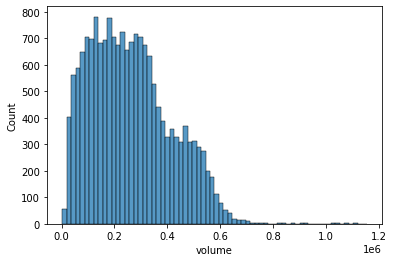

In [11]:
sns.histplot(nuclei_meta['volume'])

In [12]:
# correspondence
nucl_vol = []
for i in range(len(adata.obs)):
    idx = adata.obs.iloc[i]['orig_index']
    s = adata.obs.iloc[i]['sample']
    nucl_vol.append(nuclei_meta[np.logical_and(nuclei_meta['orig_index']==idx, nuclei_meta['sample']==s)]['volume'].values[0])

In [13]:
adata.obs['nuclei_volume'] = nucl_vol

### exploratory stats

/stanley/WangLab/envs/connie_TR/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


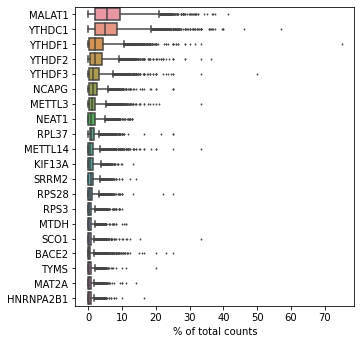

In [14]:
sc.pl.highest_expr_genes(adata, n_top=20)

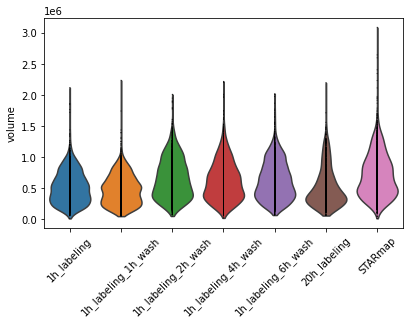

In [15]:
# cell volume
sc.pl.violin(adata, keys='volume', groupby='sample', jitter=False, rotation=45)

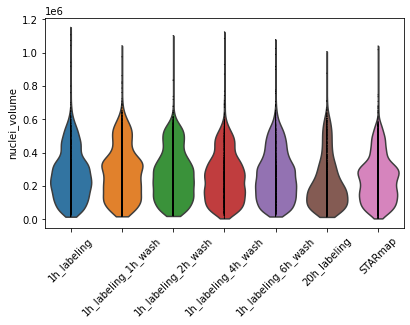

In [16]:
# nucleus volume
sc.pl.violin(adata, keys='nuclei_volume', groupby='sample', jitter=False, rotation=45)

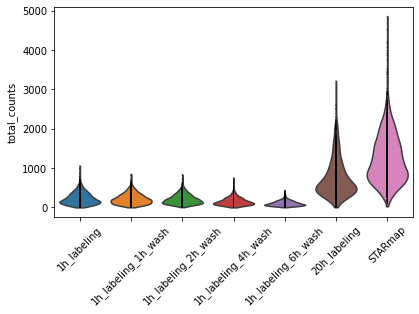

In [17]:
# total counts
sc.pl.violin(adata, keys='total_counts', groupby='sample', jitter=False, rotation=45)

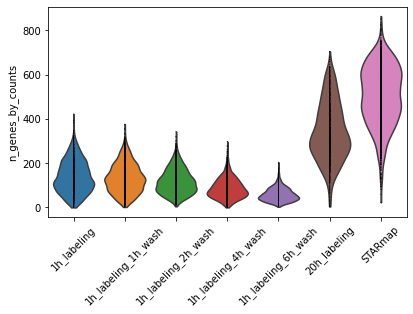

In [18]:
# n_genes per cell
sc.pl.violin(adata, keys='n_genes_by_counts', groupby='sample', jitter=False, rotation=45)

In [19]:
# normalize to anchor counts [SINGLE CELL]
X_sc_norm_anchor = adata.X / (np.reshape(np.average(adata.X[:, np.isin(adata.var.index, anchor)], axis=1), (adata.X.shape[0],1)))
adata.layers['sc_norm_anchor'] = X_sc_norm_anchor
adata.obs['sc_norm_total_wo_anchor'] = np.sum(X_sc_norm_anchor[:, np.isin(adata.var.index, anchor, invert=True)], axis=1)
adata.obs

/local/scratch/37422290.1.interactive/ipykernel_199103/359978059.py:2: RuntimeWarning: divide by zero encountered in true_divide
  X_sc_norm_anchor = adata.X / (np.reshape(np.average(adata.X[:, np.isin(adata.var.index, anchor)], axis=1), (adata.X.shape[0],1)))
/local/scratch/37422290.1.interactive/ipykernel_199103/359978059.py:2: RuntimeWarning: invalid value encountered in true_divide
  X_sc_norm_anchor = adata.X / (np.reshape(np.average(adata.X[:, np.isin(adata.var.index, anchor)], axis=1), (adata.X.shape[0],1)))


,orig_index,sample,volume,x,y,z,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,Fluo,mKO2,mKO,mAG,nuclei_volume,sc_norm_total_wo_anchor
0,0,1h_labeling_2h_wash,223130,42,1495,7,54,4.007333,74.0,4.317488,0,0,638150.0,1179754.0,81906,36.166660
1,1,1h_labeling_2h_wash,332194,47,1784,10,78,4.369448,123.0,4.820282,0,0,451177.0,2574315.0,145053,22.689655
2,2,1h_labeling_2h_wash,503831,63,4721,10,109,4.700480,177.0,5.181784,0,0,172210.0,1271848.0,59035,23.219521
3,3,1h_labeling_2h_wash,84615,32,10613,9,28,3.367296,37.0,3.637586,0,0,170994.0,706202.0,43577,36.166668
4,4,1h_labeling_2h_wash,193828,41,12873,14,69,4.248495,96.0,4.574711,0,0,1989765.0,1319980.0,97325,67.666695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17746,2602,STARmap,352710,18444,9252,19,328,5.796058,511.0,6.238325,0,0,1213342.0,76838.0,40789,887.250000
17747,2603,STARmap,347289,18477,9043,16,361,5.891644,626.0,6.440947,0,0,1861352.0,70402.0,70002,869.400635
17748,2604,STARmap,225505,18469,2662,20,263,5.575949,385.0,5.955837,0,0,29057.0,102150.0,19599,329.875000
17749,2605,STARmap,196735,18464,2742,21,232,5.451038,328.0,5.796058,0,0,75200.0,244896.0,36406,758.332703


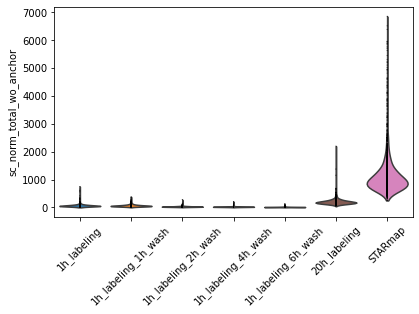

In [20]:
sc.pl.violin(adata, keys='sc_norm_total_wo_anchor', groupby='sample', jitter=False, rotation=45)

In [21]:
# nucleus percentage
cell_sum = np.sum(adata.X[:,np.isin(adata.var.index, anchor, invert=True)], axis=1)
nucl_sum = np.sum(adata.layers['nucleus'][:,np.isin(adata.var.index, anchor, invert=True)], axis=1)
adata.obs['nucl_pct'] = nucl_sum / cell_sum

/local/scratch/37422290.1.interactive/ipykernel_199103/982945933.py:4: RuntimeWarning: invalid value encountered in true_divide
  adata.obs['nucl_pct'] = nucl_sum / cell_sum


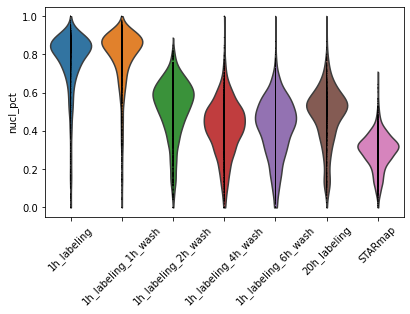

In [22]:
sc.pl.violin(adata, keys='nucl_pct', groupby='sample', jitter=False, rotation=45)

## filtration

(<matplotlib.lines.Line2D at 0x2b0b24c6fe50>,
 <matplotlib.lines.Line2D at 0x2b0b21af17c0>)

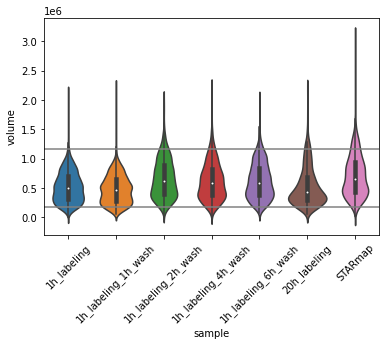

In [23]:
# cell volume (bulk)
sns.violinplot(data=adata.obs, x='sample', y='volume')
plt.xticks(rotation = 45)
bot5, up5 = np.percentile(adata.obs['volume'], q=5), np.percentile(adata.obs['volume'], q=95)
plt.axhline(y=bot5, color='grey'), plt.axhline(y=up5, color='grey')

In [24]:
# filter out above up5 and below bot5
adata.obs['filter_cell_vol'] = np.logical_and(adata.obs['volume']>bot5, adata.obs['volume']<up5)

(<matplotlib.lines.Line2D at 0x2b0b270efe80>,
 <matplotlib.lines.Line2D at 0x2b0b270a0820>)

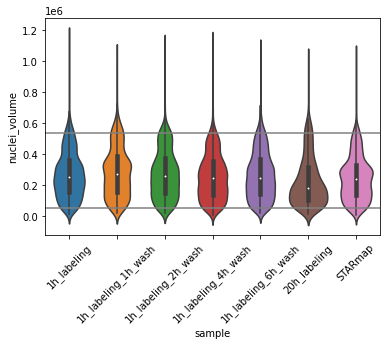

In [25]:
# nuclei volume (bulk)
sns.violinplot(data=adata.obs, x='sample', y='nuclei_volume')
plt.xticks(rotation = 45)
bot5, up5 = np.percentile(adata.obs['nuclei_volume'], q=5), np.percentile(adata.obs['nuclei_volume'], q=95)
plt.axhline(y=bot5, color='grey'), plt.axhline(y=up5, color='grey')

In [26]:
adata.obs['filter_nucl_vol'] = np.logical_and(adata.obs['nuclei_volume']>bot5, adata.obs['nuclei_volume']<up5)

In [27]:
# total counts (per sample)
counts_filter = dict()
for sample in sample_list:
    obs = adata.obs[adata.obs['sample']==sample]
    _bot5, _up5 = np.percentile(obs['total_counts'], q=5), np.percentile(obs['total_counts'], q=95)
    counts_filter[sample] = (_bot5, _up5)

In [28]:
adata_counts_filter = []
for i in range(len(adata.obs)):
    _sample = adata.obs.iloc[i]['sample']
    _tot = adata.obs.iloc[i]['total_counts']
    bot, up = counts_filter[_sample]
    if _tot > bot:
        if _tot < up:
            adata_counts_filter.append(True)
            continue
    adata_counts_filter.append(False)

In [29]:
adata.obs['filter_counts'] = adata_counts_filter

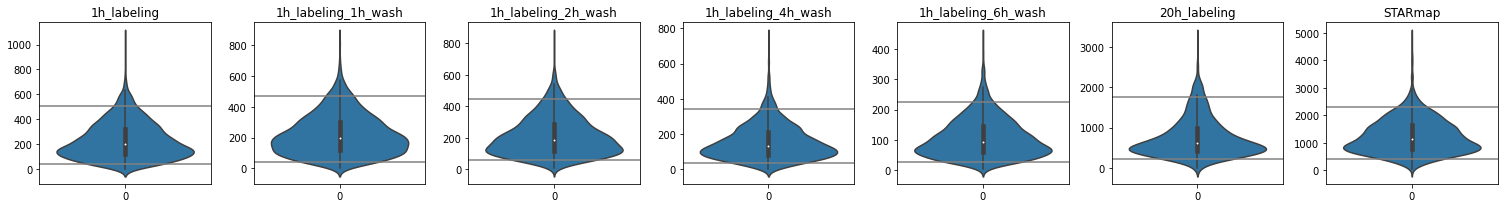

In [30]:
fig, ax = plt.subplots(1, n_samples, figsize=(3*n_samples,3))
for i, sample in enumerate(sample_list):
    sns.violinplot(data=adata.obs[adata.obs['sample']==sample]['total_counts'], ax=ax[i]).set_title(sample)
    thres = counts_filter[sample]
    ax[i].axhline(y=thres[0], color='grey'), ax[i].axhline(y=thres[1], color='grey')
plt.tight_layout()

In [ ]:
# sc.pp.filter_cells(adata, min_genes=10)
# sc.pp.filter_cells(adata, min_counts=50)
# sc.pl.violin(adata, keys='total_counts', groupby='sample', jitter=False, rotation=45)
# adata

In [31]:
adata.obs['filter'] = np.all(adata.obs[['filter_cell_vol', 'filter_nucl_vol', 'filter_counts']], axis=1)

In [ ]:
# adata.write_h5ad('2022-10-21-TEMPOrevision1000Gene-raw-qc.h5ad')

In [46]:
# save a filtered copy
import anndata
adata_flt = anndata.AnnData(X=adata.X[adata.obs['filter']], obs=adata.obs[adata.obs['filter']], var=pd.DataFrame(index=adata.var.index))
# adata_flt.write_h5ad('2022-10-21-TEMPOrevision1000Gene-filtered.h5ad')

check result

In [4]:
adata = sc.read_h5ad('/stanley/WangLab/Connie/02.TEMPOmap/03.revision1000Gene/adata/2022-10-21-TEMPOrevision1000Gene-raw-qc.h5ad')
adata

AnnData object with n_obs × n_vars = 17741 × 998
    obs: 'orig_index', 'sample', 'volume', 'x', 'y', 'z', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'Fluo', 'mKO2', 'mKO', 'mAG', 'nuclei_volume', 'sc_norm_total_wo_anchor', 'nucl_pct', 'filter_cell_vol', 'filter_nucl_vol', 'filter_counts', 'filter'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'max_counts'
    uns: 'sample_colors'
    layers: 'cytoplasm', 'er', 'nucleus', 'outer_cytoplasm', 'sc_norm_anchor'

In [5]:
adata_flt = sc.read_h5ad('/stanley/WangLab/Connie/02.TEMPOmap/03.revision1000Gene/adata/2022-10-21-TEMPOrevision1000Gene-filtered.h5ad')
adata_flt

AnnData object with n_obs × n_vars = 14359 × 998
    obs: 'orig_index', 'sample', 'volume', 'x', 'y', 'z', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'Fluo', 'mKO2', 'mKO', 'mAG', 'nuclei_volume', 'sc_norm_total_wo_anchor', 'nucl_pct', 'filter_cell_vol', 'filter_nucl_vol', 'filter_counts', 'filter'

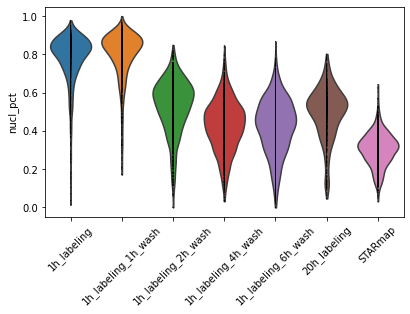

In [11]:
# nucleus percentage
sc.pl.violin(adata_flt, keys='nucl_pct', groupby='sample', jitter=False, rotation=45)

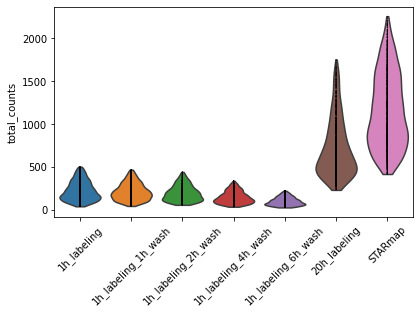

In [7]:
# total counts
fig = sc.pl.violin(adata_flt, keys='total_counts', groupby='sample', jitter=False, rotation=45, show=False)
plt.savefig('/stanley/WangLab/Connie/02.TEMPOmap/03.revision1000Gene/figures/counts_per_cell.pdf')

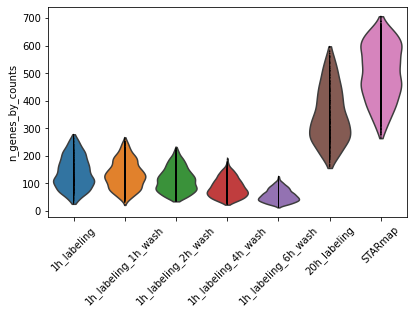

In [13]:
# n_genes per cell
fig = sc.pl.violin(adata_flt, keys='n_genes_by_counts', groupby='sample', jitter=False, rotation=45, show=False)
# plt.savefig('/stanley/WangLab/Connie/02.TEMPOmap/03.revision1000Gene/figures/n_genes_per_cell.pdf')

In [15]:
adata_flt.obs

,orig_index,sample,volume,x,y,z,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,...,mKO2,mKO,mAG,nuclei_volume,sc_norm_total_wo_anchor,nucl_pct,filter_cell_vol,filter_nucl_vol,filter_counts,filter
0,0,1h_labeling_2h_wash,223130,42,1495,7,54,4.007333,74.0,4.317488,...,0,638150.0,1179754.0,81906,36.166660,0.483871,True,True,True,True
1,1,1h_labeling_2h_wash,332194,47,1784,10,78,4.369448,123.0,4.820282,...,0,451177.0,2574315.0,145053,22.689655,0.531915,True,True,True,True
2,2,1h_labeling_2h_wash,503831,63,4721,10,109,4.700480,177.0,5.181784,...,0,172210.0,1271848.0,59035,23.219521,0.066176,True,True,True,True
4,4,1h_labeling_2h_wash,193828,41,12873,14,69,4.248495,96.0,4.574711,...,0,1989765.0,1319980.0,97325,67.666695,0.540230,True,True,True,True
5,5,1h_labeling_2h_wash,317746,61,2272,11,63,4.158883,81.0,4.406719,...,0,4043382.0,175380.0,118757,33.500000,0.432836,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17742,2598,STARmap,585749,18456,1722,19,497,6.210600,1010.0,6.918695,...,0,1454020.0,150795.0,207900,1003.000000,0.333998,True,True,True,True
17743,2599,STARmap,619667,18457,4388,17,440,6.089045,872.0,6.771935,...,0,377031.0,6094188.0,176480,1010.334534,0.249423,True,True,True,True
17744,2600,STARmap,610088,18443,3161,15,512,6.240276,1085.0,6.990256,...,0,899915.0,81757.0,99645,1512.003906,0.163889,True,True,True,True
17745,2601,STARmap,533619,18465,4627,16,473,6.161207,1012.0,6.920671,...,0,190295.0,3143687.0,94551,1173.667114,0.118290,True,True,True,True


In [17]:
print('STARmap n_genes_per_cell median: ', np.median(adata_flt.obs[adata_flt.obs['sample']=='STARmap']['n_genes_by_counts']))
print('STARmap n_genes_per_cell median: ', np.median(adata_flt.obs[adata_flt.obs['sample']=='1h_labeling']['n_genes_by_counts']))

STARmap n_genes_per_cell median:  502.0
STARmap n_genes_per_cell median:  133.0
